In [1]:
#importing modules
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
plt.rcParams['figure.figsize'] = 15, 10

# Initialize the transform operation
transform = torchvision.transforms.Compose([
   torchvision.transforms.ToTensor(),
   torchvision.transforms.Normalize((0.5), (0.5))
])

# Download and load the training dataset
trainset = torchvision.datasets.FashionMNIST(root='./FashionMNIST', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Download and load the testing dataset
testset = torchvision.datasets.FashionMNIST(root='./FashionMNIST', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 26421880/26421880 [00:14<00:00, 1825543.06it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 122353.44it/s]


Extracting ./FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:08<00:00, 494205.31it/s] 


Extracting ./FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 21876673.75it/s]

Extracting ./FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/FashionMNIST/raw



In [2]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),  # 1x28x28 -> 16x14x14
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),  # 16x14x14 -> 32x7x7
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),  # 32x7x7 -> 16x14x14
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),  # 16x14x14 -> 1x28x28
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Instantiate the model
model = Autoencoder()
criterion = torch.nn.MSELoss()
num_epochs = 10
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1/10], Loss: 0.6205
Epoch [2/10], Loss: 0.5750
Epoch [3/10], Loss: 0.5725
Epoch [4/10], Loss: 0.5714
Epoch [5/10], Loss: 0.5708
Epoch [6/10], Loss: 0.5704
Epoch [7/10], Loss: 0.5702
Epoch [8/10], Loss: 0.5700
Epoch [9/10], Loss: 0.5699
Epoch [10/10], Loss: 0.5699


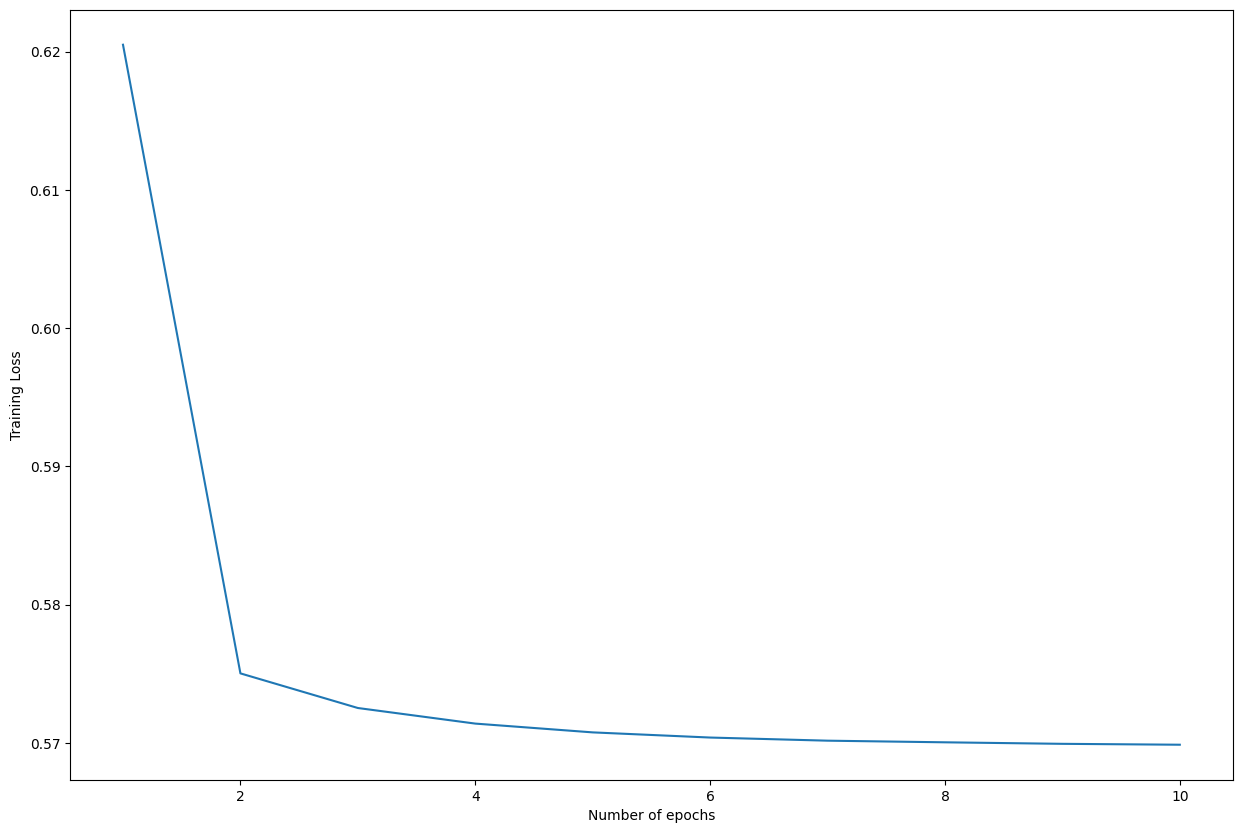

In [3]:
# Create empty list to store the training loss
train_loss = []
# Create empty dictionary to store the images and their reconstructed outputs
outputs = {}

# Loop through each epoch
for epoch in range(num_epochs):
   # Initialize variable for storing the running loss
   running_loss = 0
   # Loop through each batch in the training data
   for batch in trainloader:

      # Load the images and their labels
      img, _ = batch
      # Reshape the input images into a 4D tensor
      img = img.view(-1, 1, 28, 28)
      # Generate the output for the autoencoder model
      out = model(img)
      # Calculate the loss between the input and output images
      loss = criterion(out, img)
      # Reset the gradients
      optimizer.zero_grad()
      # Compute the gradients
      loss.backward()
      # Update the weights
      optimizer.step()
      # Increment the running loss by the batch loss
      running_loss += loss.item()
   # Calculate the average running loss over the entire dataset
   running_loss /= len(trainloader)
   # Add the running loss to the list of training losses
   train_loss.append(running_loss)
   # Store the input and output images for the last batch
   outputs[epoch+1] = {'input': img, 'output': out}

   print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}")

# Plot the training loss over epochs
plt.plot(range(1, num_epochs+1), train_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training Loss")
plt.show()


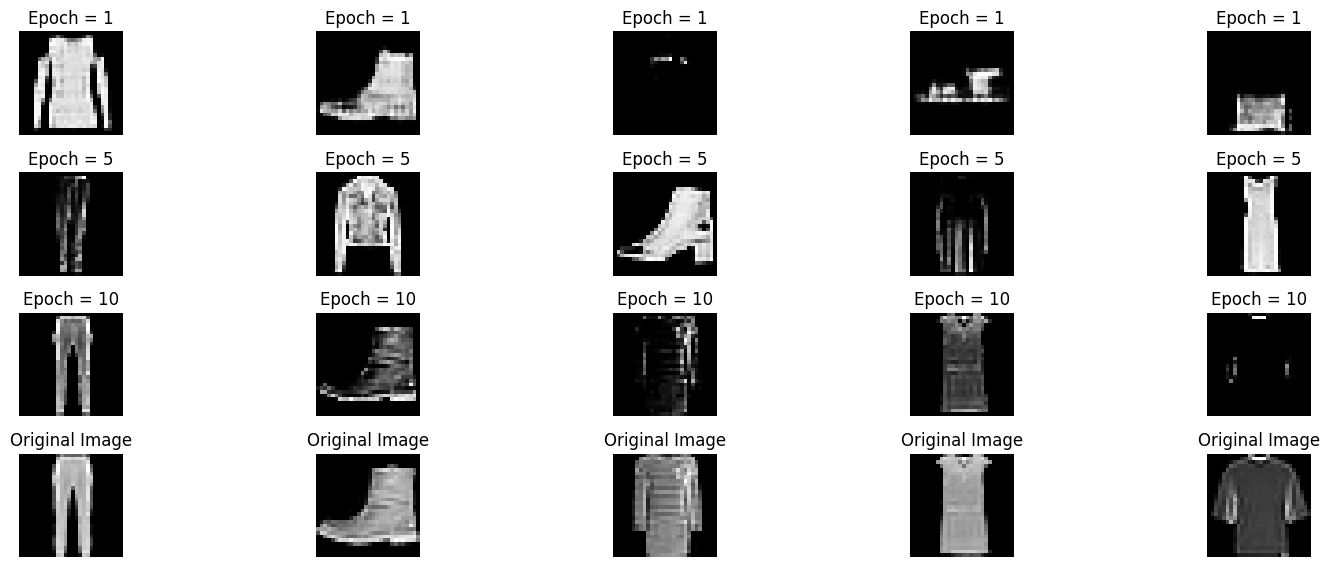

In [4]:
# Plot the re-constructed images
# Initializing the counter
count = 1
# Plotting the reconstructed images
list_epochs = [1, 5, 10]

# Iterate over specified epochs
for val in list_epochs:
    # Extract recorded information
    if val in outputs:
        temp = outputs[val]['output'].detach().numpy()
        title_text = f"Epoch = {val}"

        # Plot first 5 images of the last batch
        for idx in range(5):
            plt.subplot(7, 5, count)
            plt.title(title_text)
            plt.imshow(temp[idx].reshape(28, 28), cmap='gray')
            plt.axis('off')

            # Increment the count
            count += 1
    else:
        print(f"No output recorded for epoch {val}")

# Plot of the original images

# Iterating over first five
# images of the last batch
for idx in range(5):
    # Obtaining image from the dictionary
    if 10 in outputs:
        val = outputs[10]['input']

        # Plotting image
        plt.subplot(7, 5, count)
        plt.imshow(val[idx].reshape(28, 28), cmap='gray')
        plt.title("Original Image")
        plt.axis('off')

        # Increment the count
        count += 1
    else:
        print("No original images recorded.")

plt.tight_layout()
plt.show()


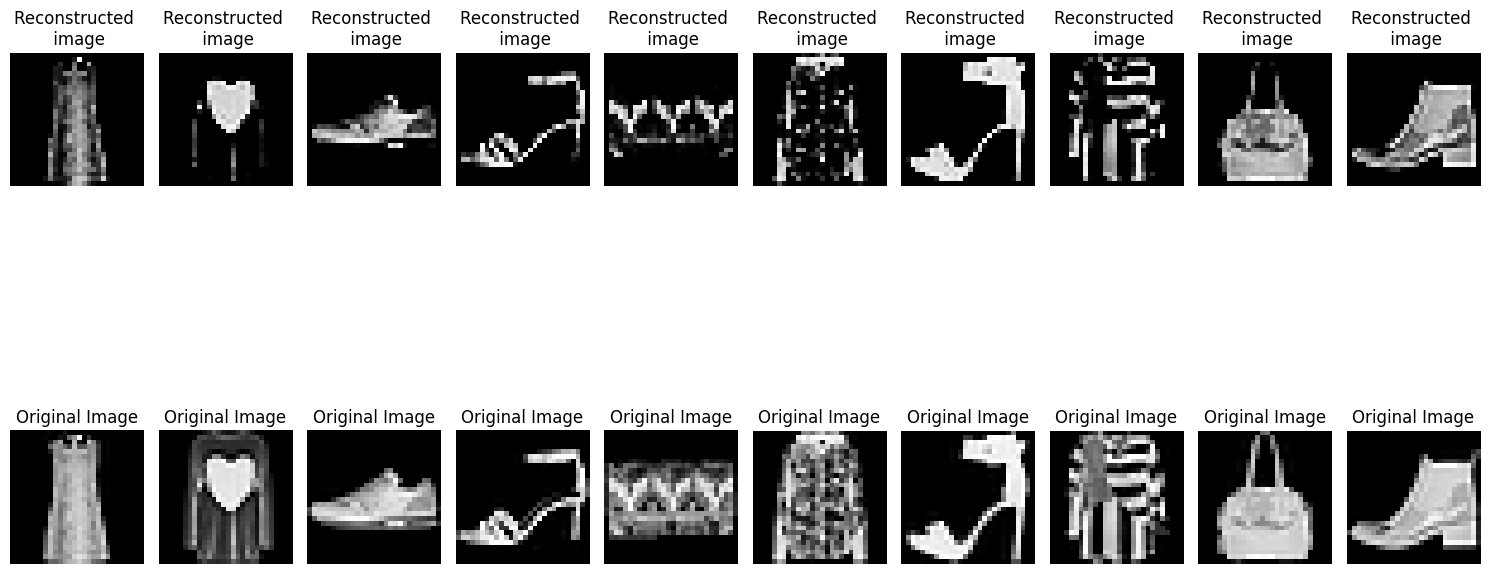

In [5]:
outputs = {}

# Extract the last batch dataset
img, _ = list(testloader)[-1]

# No need to reshape here, since the images are already in the correct shape

# Generate output
out = model(img)

# Storing results in the dictionary
outputs['img'] = img
outputs['out'] = out

# Initialize subplot count
count = 1
val = outputs['out'].detach().numpy()

# Plot first 10 images of the batch
for idx in range(10):
    plt.subplot(2, 10, count)
    plt.title("Reconstructed \n image")
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.axis('off')

    # Increment subplot count
    count += 1

# Plotting original images
# Plotting first 10 images
for idx in range(10):
    val = outputs['img']
    plt.subplot(2, 10, count)
    plt.imshow(val[idx].reshape(28, 28), cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    count += 1

plt.tight_layout()
plt.show()


In [6]:
import numpy as np

# Function to calculate Mean Squared Error (MSE)
def calculate_mse(original, reconstructed):
    return np.mean(np.square(original - reconstructed))

# Function to calculate Peak Signal-to-Noise Ratio (PSNR)
def calculate_psnr(original, reconstructed):
    mse = calculate_mse(original, reconstructed)
    max_pixel = 1.0  # Assuming pixel values are normalized to [-1, 1]
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

# Calculate metrics for the last batch of test data
mse_val = calculate_mse(outputs['img'].numpy(), outputs['out'].detach().numpy())
psnr_val = calculate_psnr(outputs['img'].numpy(), outputs['out'].detach().numpy())

print("Metrics for the last batch of test data:")
print("Mean Squared Error (MSE):", mse_val)
print("Peak Signal-to-Noise Ratio (PSNR):", psnr_val, "dB")


Metrics for the last batch of test data:
Mean Squared Error (MSE): 0.6449318
Peak Signal-to-Noise Ratio (PSNR): 1.9048622321546735 dB
